In [6]:
#import necessary libraries
import pandas as pd
import glob
import h5py
import xarray as xr
import numpy as np
import scipy.sparse 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore,kstest
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
import random
import os
import json

#import my functions
from spatial_coding_functions import event_numbers,make_firing_rate_maps,make_binary

In [7]:
#initializing the foler with the data

mouse_ID='WEZ8917'
condition='24hr_poststim'

home_folder='C:\\Users\\Theodore Tamiolakis\\OneDrive\\PhD\\Lab'

data_folder=f'{home_folder}\\data\\representational_drift' #r means that I will treat the string as a raw string (/ are special characters)
results_folder=f'{home_folder}\\Results\\representational_drift\\{mouse_ID}\\{condition}\\'
jason_path=f'{results_folder}\\data.json'

#storing data to jason
mouse_info= {
    "mouse_ID":mouse_ID,
    "condition": condition
}
jason_indent=2
with open(jason_path, "w") as json_file:
    json.dump(mouse_info, json_file,indent=jason_indent)


# Check if results folder exists, create it if not
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

cnmf_file=glob.glob(f"{data_folder}\\231108_{mouse_ID}_{condition}*.hdf5") #data from cnmf
belt_file=glob.glob(f"{data_folder}\\231108_{mouse_ID}_{condition}*.h5") #data from lab view and lfp

#check that there is only one file out of each

if len(cnmf_file)>1 or len(belt_file)>1:
    print ("error. two files with similar conditions found")
else:
    print ("all good with naming the files. continue")

all good with naming the files. continue


In [8]:
#since glob glob is a list I take the first element out of belt file and cmf file. I have checked begore that it is only one
cnmf_file,belt_file=cnmf_file[0],belt_file[0]

#preprocessing the data

#opening the hpf5 file
fluo_hdf=h5py.File(cnmf_file)['estimates']['C']
#convert it in a dataframe
fluo_hdf=pd.DataFrame(fluo_hdf)


#opening the stripe folder
stripe_hdf=h5py.File(belt_file)['inferred']['belt_dict']['stripes']
stripe_hdf=pd.DataFrame(stripe_hdf)
fluo_hdf_r=fluo_hdf.T #swap columns and rows in fluo hdf
n_cells=fluo_hdf_r.shape[1]

#normazing the whole panda frame by applying z score
fluo_hdf_r=fluo_hdf_r.apply(zscore,axis=0)
#identifying and storing the number of units
units_n=fluo_hdf_r.shape[1]



1.creating panda frames for running distance, speed, time and immobility
2.adding all of them into the intial panda frame so that I can analyze everything at the same time

In [9]:
# panda frame for time
time_hdf=h5py.File(belt_file)['inferred']['belt_dict']['tsscn']
time_hdf=pd.DataFrame(time_hdf)
time_hdf.columns=['Time (ms)']
#panda frame for distance
distance_hdf=h5py.File(belt_file)['inferred']['belt_scn_df']['distance']
distance_hdf=pd.DataFrame(distance_hdf)
distance_hdf.columns=['Distance']
# panda frame for speed
speed_hdf=h5py.File(belt_file)['inferred']['belt_scn_df']['speed']
speed_hdf=pd.DataFrame(speed_hdf)
speed_hdf.columns=['Speed']
# panda frame for number of rounds
rounds_hdf=h5py.File(belt_file)['inferred']['belt_scn_df']['rounds']
rounds_hdf=pd.DataFrame(rounds_hdf)
rounds_hdf.columns=['Rounds']
rounds_hdf=rounds_hdf.astype(int)
# panda frame for running(yes or no running)
running_hdf=h5py.File(belt_file)['inferred']['belt_scn_df']['running']
running_hdf=pd.DataFrame(running_hdf)
running_hdf.columns=['Running']
running_hdf=running_hdf.astype(int)

#####################################################################################################################

#adding all the parameters in one panda frame
fluo_hdf_r = pd.concat([fluo_hdf_r, time_hdf, distance_hdf, speed_hdf, rounds_hdf, running_hdf], axis=1, ignore_index=True)
# Create a mapping dictionary for column renaming
rename_mapping = {old_col: new_col for old_col, new_col in zip(fluo_hdf_r.columns[-5:], ['Time (ms)', 'Distance', 'Speed', 'Rounds', 'Running'])}
# Rename the columns
fluo_hdf_r = fluo_hdf_r.rename(columns=rename_mapping)


I want to plot as I test the different distances every time in every round to compare.
all the rounds should be approximately 1500

In [25]:
wanted_distance=1500
n_rounds=fluo_hdf_r['Rounds'].max()
rounds=[]
for round in range(1,n_rounds+1):
    dis=fluo_hdf_r[fluo_hdf_r['Rounds']==round].iloc[-1]['Distance']
    if abs(dis-wanted_distance)<15:
        rounds.append(round)

num_rounds=len(rounds)
print(f'Rounds: {rounds}\n Number of rounds: {num_rounds})

#storing round info to jason
rounds_info= {
    "rounds with 150 cm":rounds,
    "number of rounds": num_rounds
}

mouse_info.update(rounds_info)
with open(jason_path, "w") as json_file:
    json.dump(mouse_info, json_file,indent=jason_indent)




#all the distances approximately 1.5 m

[1, 2, 3, 4, 5, 6, 7]


processing the data

In [27]:
data=fluo_hdf_r                     #renaming data so that it is easier to process them
data=data[data['Speed']>0]   #taking only the timepoints when the mouse moves
data=data[data['Rounds'].isin(rounds)]         #only taking the data of 8 rounds because this is where the belt approximates 150 cm

calculate spatial firing map for each round indivudually. then I can average them easily.
no need to do it from the beginning

In [28]:
# Extract relevant columns
fluorescence_traces = data.iloc[:, :units_n]  # Columns containing fluorescence traces
distance = data['Distance']  # Column containing distance on the linear belt
speed = data['Speed']   # Column containing speed
rounds = data['Rounds']   # Column containing the number of rounds
running = data['Running'] # Column containing running status


num_bins = 150
num_units=units_n

#storing round info to jason
units_info= {
    "number_of units":units_n
}

mouse_info.update(units_info)
with open(jason_path, "w") as json_file:
    json.dump(mouse_info, json_file,indent=jason_indent)



#making the firing rate map for every cell and every round

firing_rate_maps=make_firing_rate_maps(data,num_rounds,num_units,num_bins)

#calculate the average firing rate map for every cell

avr_firing_rate_maps=np.mean(firing_rate_maps,axis=1)

#caclulate the event map for every cell
#meaning I will make a binary array where every peak of the activity is 1 and everything else is zero

events_per_cell=make_binary(firing_rate_maps,peak_threshold=3,peak_distance=10)




In [ ]:
#identify the units which have at least a certain amount of events

threshold=4 #it means that I take events as something above 4 standrad deviations
peak_window=20 #it means that I look for local maxima within 20 cells in the panda frame
n_events_threshold=3 #how many events do I want at least per cell

cells_with_events=[]
for i in range(units_n):
    if len(event_numbers(data[i],threshold,peak_window))>n_events_threshold:
        cells_with_events.append(i)

plotting
1. z score activity per round per cell
2. average z-score activity for all the rounds
3. spatial vector analysis schematic and histogram with comparison of shuffling data
4. statistical significanc e analysis using colmogorov-smirnov test

changed code for plotting

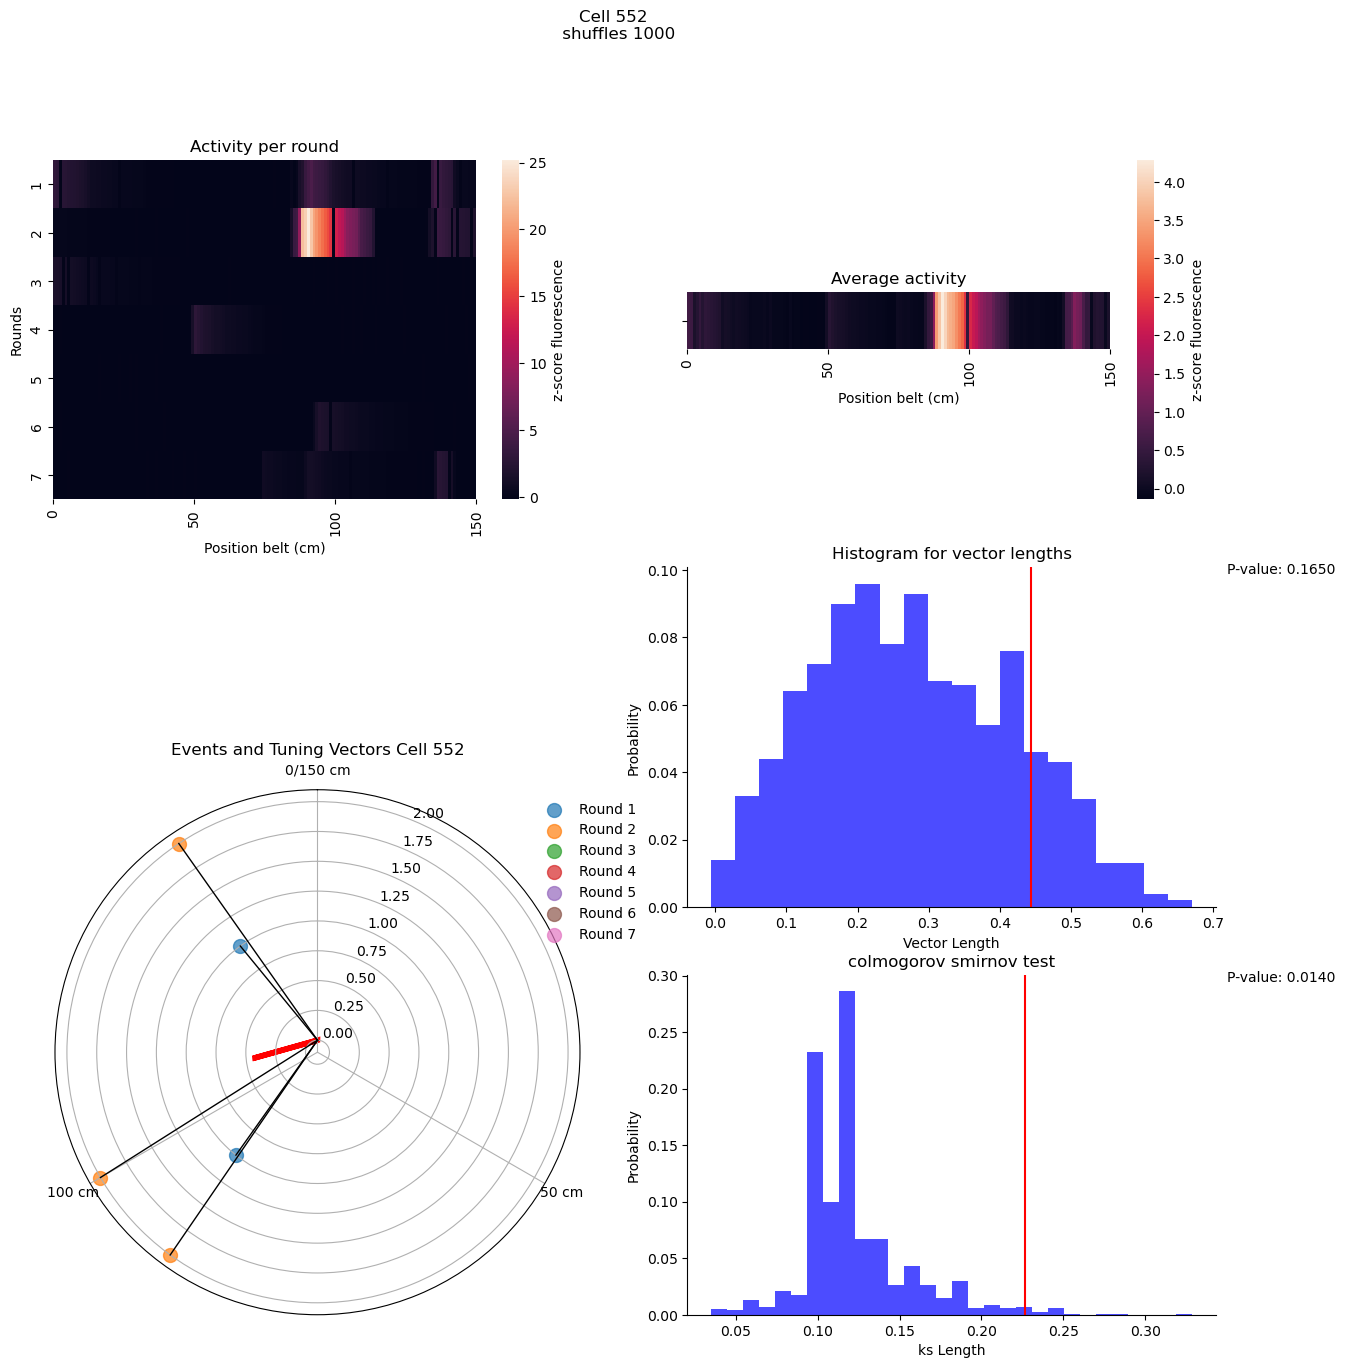

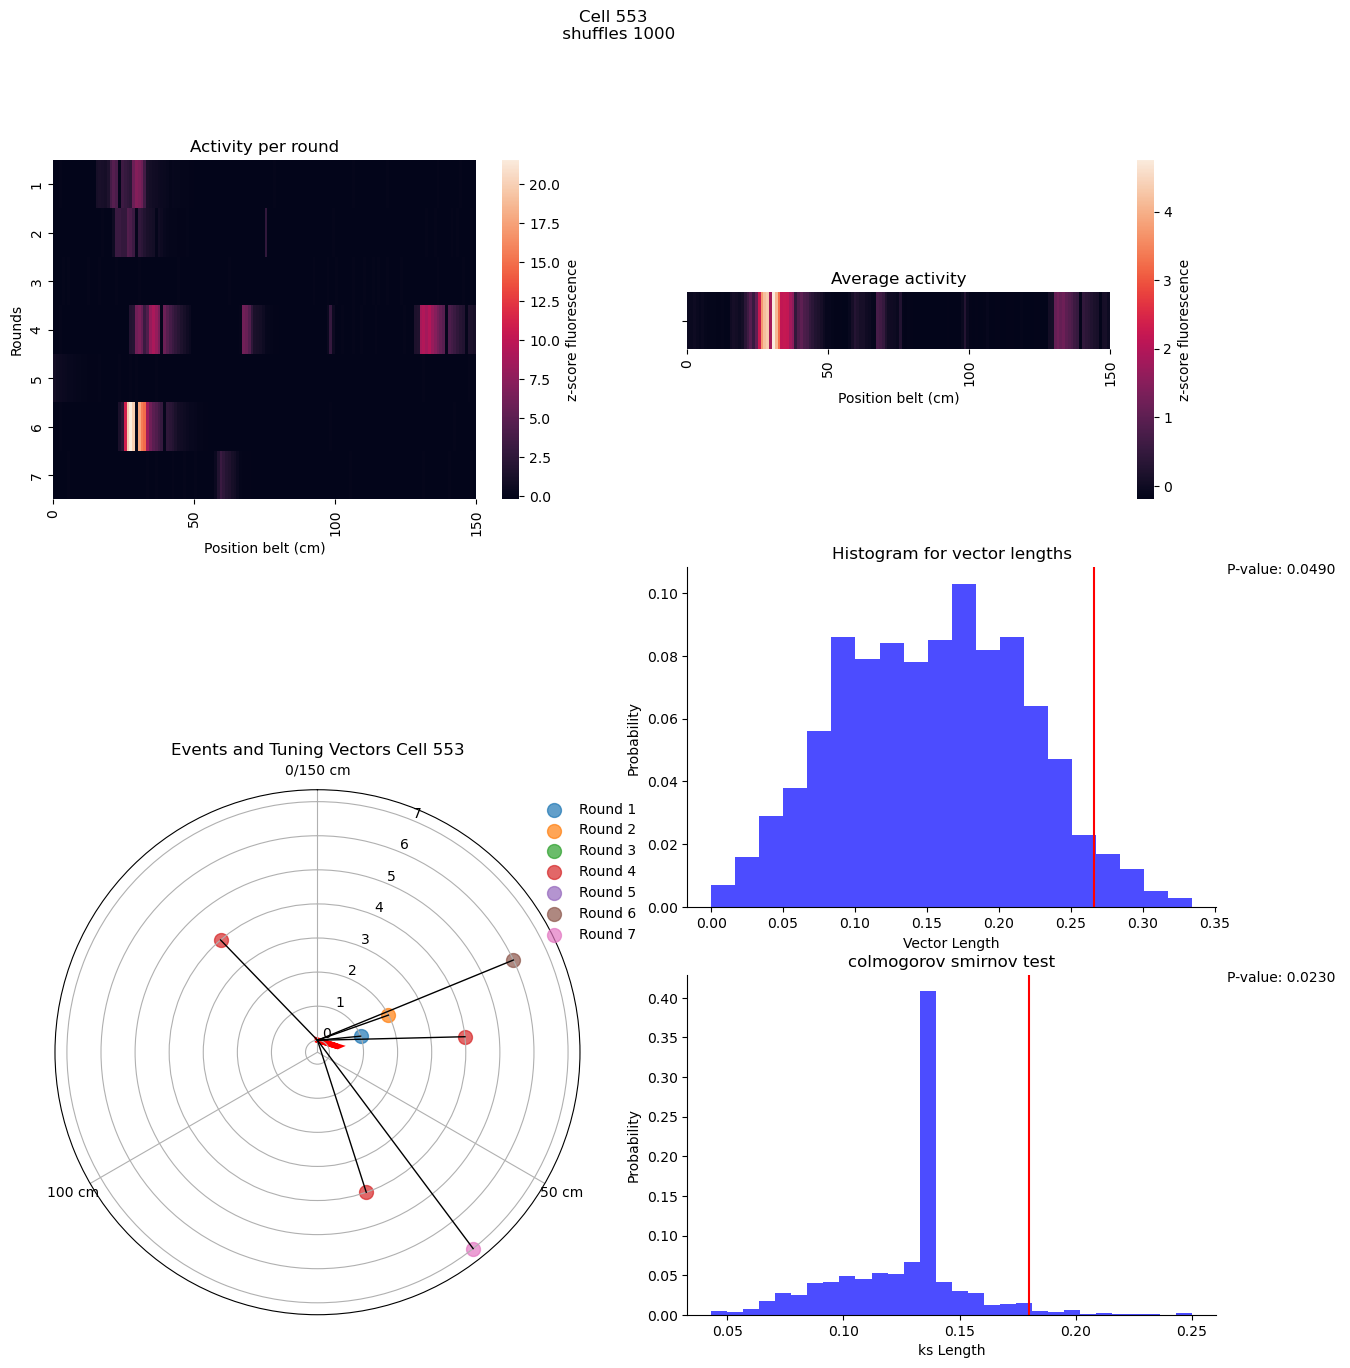

: 

In [9]:
#INITIAL PARAMETERS

n_cells=units_n #number of cells that I want to permutate
peak_threshold=3 #amount of sd from the baseline activity
peak_distance=10 #distance in cells that I am looking for local maxima
belt_length=150 #(in cm)
shuffling_times=1000  #time of shuffling for statistical comparison

#storing round info to jason
peak_parameters_info= {
    "threshold":peak_threshold,
    "peak distance (moving window for peaks)":peak_distance
}

mouse_info.update(peak_parameters_info)
with open(jason_path, "w") as json_file:
    json.dump(mouse_info, json_file,indent=2)



#creating pdfs for significant and non significant cells sop that I can review them after
# Create two pdf files
significant_cells = PdfPages(results_folder+'significant_place_cells.pdf')
non_significant_cells = PdfPages(results_folder+'non_significant_place_cells.pdf')


angles = np.linspace(0, 2*np.pi, num_bins, endpoint=False) #initializing the circle with 150 bins corresponding to the distance on the belt

place_cells_with_both_methods=[]
place_cells_tuned_vector=[]
place_cell_colmogorov_smirnov_test=[]

for cell in range(n_cells):
    
    data=firing_rate_maps[cell]
    data_avg=avr_firing_rate_maps[cell]

    events_data = events_per_cell[cell]  # Assuming you have your actual events data
    peak_n=np.sum(events_data) #finding the number of peaks during the whole time the mouse was running

    #events=events_data
    if peak_n>4: #I follow the logic from the paper of Danielson and Niko. I only used cells for visualization where I have at least 4 events

        ####################################################
        # creating the plot where I will put all of the suplots inside
        ###################################################

        fig, ax = plt.subplots(3, 2, figsize=(15, 15))
        fig.suptitle(f'Cell {cell} \n shuffles {shuffling_times}')

        ###################################################
        #plotting fluorescence for every round in the first subplot
        ##################################################

        sns.heatmap(data,ax=ax[0,0],cbar_kws={'label': 'z-score fluorescence'})
        ax[0,0].set_ylabel('Rounds')
        ax[0,0].set_title("Activity per round")
        ax[0,0].set_xlabel('Position belt (cm)')
        ax1_labels=range(1,num_rounds+1)
        ax[0,0].set_yticklabels(ax1_labels)
        custom_ticks = [0, 50, 100, 150]  # Specify the positions where you want the ticks
        custom_labels = ['0', '50', '100', '150']  # Specify the labels for the ticks
        ax[0,0].set_xticks(custom_ticks)
        ax[0,0].set_xticklabels(custom_labels)

        ###################################################
        #plotting average z=score for every round in the second subplot
        ##################################################


        avg_activity = pd.DataFrame(data_avg, columns=['']) #taking the average activity of the cell and converting it to data frame to plot it
        sns.heatmap(avg_activity.transpose(),ax=ax[0,1],cbar_kws={'label': 'z-score fluorescence'})

        #changing the size of the second subplot
        position = ax[0,1].get_position()  # Get the current position of the subplot
        ax[0,1].set_title("Average activity")
        position.y0 -= -0.1  # Decrease the bottom boundary
        position.y1 *= 0.9  # Decrease the height
        ax[0,1].set_position(position)  # Set the new position
        ax[0,1].set_ylabel('')
        ax[0,1].set_xlabel('Position belt (cm)')
        ax[0,1].set_xticks(custom_ticks)
        ax[0,1].set_xticklabels(custom_labels)

        ###################################################
        #plotting spatial tuned vector figure
        ##################################################


        # Create a polar plot with circles representing each round
        
        ax[1,0] = plt.subplot(2,2,3,projection='polar')
        ax[1,0].set_theta_direction(-1)  # Set clockwise direction
        ax[1,0].set_theta_zero_location('N')  # Set zero angle at North

        # Customize the tick labels on the circles (bins) so  that I can see the distance on the belt instead of degrees
        circle_ticks = [0, 120, 240]  # Tick positions in degrees
        circle_labels = ['0/150 cm', '50 cm', '100 cm']  # Labels for the ticks
        ax[1,0].set_xticks(np.radians(circle_ticks))  # Set the tick positions in radians
        ax[1,0].set_xticklabels(circle_labels)  # Set the tick labels

        # Plot events on the circle
        for i, events_round in enumerate(events_data):
            event_angles = angles[np.where(events_round == 1)] #I found the angles where I have events
            event_radii = np.ones_like(event_angles) * (i + 1)  # Adjust the radius for each round
            ax[1,0].scatter(event_angles, event_radii, s=100, label=f'Round {i+1}', alpha=0.7)
            for angle, radius in zip(event_angles, event_radii):
                ax[1,0].plot([0, angle], [0, radius], color='black', linestyle='-', linewidth=1)  # Connect center to event dot. better for visualization

        # Calculate average direction using Cartesian coordinates
        x_coords = []
        y_coords = []
        for i, events_round in enumerate(events_data):
            event_angles = angles[np.where(events_round == 1)]
            event_radii = np.ones_like(event_angles) * (i + 1)  # Adjust the radius for each round
            x_coords.extend(np.cos(event_angles)/(i + 1))
            y_coords.extend(np.sin(event_angles)/(i + 1))

        # Sum the coordinates . I divide it with number of events. instead of number of rounds MAYBE THIS WOULD NEED TO CHANGE
        sum_x = np.sum(x_coords)/ peak_n
        sum_y = np.sum(y_coords)/ peak_n

        # Convert the sum of coordinates to polar coordinates
        sum_direction = np.arctan2(sum_y, sum_x)  # Note: y comes before x in arctan2
        sum_magnitude = np.sqrt(sum_x**2 + sum_y**2)

        # Plot the average tuning vector as an arrow
        ax[1,0].arrow(0, 0, sum_direction, sum_magnitude, head_width=0, head_length=0,linewidth=4, fc='red', ec='red')

        # Customize plot
        ax[1,0].set_title(f'Events and Tuning Vectors Cell {cell}')
        ax[1,0].legend(loc='upper left',bbox_to_anchor=(0.9, 1), frameon=False)
        ax[1,0].grid(True)

        # Convert average direction from radians to degrees
        sum_direction_degrees = np.degrees(sum_direction)
        # Map the sum direction to the corresponding position on the belt
        position_on_belt = (sum_direction_degrees % 360) * (belt_length / 360)

        ###########
        #plotting the histogram of the vector lengths coming from the shuffled data and compare it with the actual vector length
        ###########

        shuffled_vector_lengths=[]

        for n in range(shuffling_times):
            #shuffling every row separately
            shuffled_events_data = events_data.copy()  # Make a copy to avoid modifying original data
            for row in shuffled_events_data:
                np.random.shuffle(row)  # Shuffle the spiking events within each round independently

            # Calculate average direction and magnitude for shuffled data. same logic as before exactly
            shuffled_x_coords = []
            shuffled_y_coords = []
            for i, events_round in enumerate(shuffled_events_data):
                event_angles = angles[np.where(events_round == 1)]
                event_radii = np.ones_like(event_angles) * (i + 1)  # Adjust the radius for each round
                shuffled_x_coords.extend(np.cos(event_angles)/(i + 1))
                shuffled_y_coords.extend(np.sin(event_angles)/(i + 1))

            shuffled_sum_x = np.sum(shuffled_x_coords)/ peak_n
            shuffled_sum_y = np.sum(shuffled_y_coords)/ peak_n
            shuffled_sum_direction = np.arctan2(shuffled_sum_y, shuffled_sum_x)
            shuffled_sum_magnitude = np.sqrt(shuffled_sum_x**2 + shuffled_sum_y**2)
            shuffled_vector_lengths.append(shuffled_sum_magnitude)

            # Map the shuffled average direction to the corresponding position on the belt
            shuffled_position_on_belt = (np.degrees(shuffled_sum_direction) % 360) * (150 / 360)


        ###########
        #making the histogram with the shuffled data and our actual vector length
        ###########

        # Calculate histogram
        counts, bins = np.histogram(shuffled_vector_lengths, bins=20)

        # Calculate probabilities
        total_samples = len(shuffled_vector_lengths)
        probabilities = counts / total_samples

        # Plot histogram with probabilities
        ax[1,1].bar(bins[:-1], probabilities, width=np.diff(bins), color='blue', alpha=0.7)
        ax[1,1].axvline(x=sum_magnitude,color='red')
        ax[1,1].set_xlabel('Vector Length')
        ax[1,1].set_ylabel('Probability')
        # Remove right and upper axes
        ax[1,1].spines['right'].set_visible(False)
        ax[1,1].spines['top'].set_visible(False)
        ax[1,1].set_title('Histogram for vector lengths')
        ax[1,1].grid(False)


        # comparing it with the actual vector lenth now)
        # Actual vector length
        actual_length = sum_magnitude  # Example value


        # Calculate the p-value
        larger_lengths_count = np.sum(np.array(shuffled_vector_lengths) > actual_length)
        total_samples = len(shuffled_vector_lengths)
        p_value_vector = larger_lengths_count / total_samples
        # Annotate the p-value on the upper side of the plot

        # Create a legend entry with the p-value
        p_value_text = f'P-value: {p_value_vector:.4f}'
        p_value_patch = mpatches.Patch(color='none', label=p_value_text)

        # Add the legend with the custom entry
        ax[1,1].legend(handles=[p_value_patch],loc='upper right', bbox_to_anchor=(1.25, 1.05),frameon=False)

        ###################################################
        #plotting the histogram from colmogorov smirnov test
        ##################################################


        ###########################
        # I will shuffle once. and then I will compare the shufle data with my original data. the colmogorov smiron value will be the value that I will compare later
        # later I will shuffle the data 1000 times and I will compare them to the first suffling data
        ##############################

        shuffled_ks=[] #array where I will put the ks distances where I will compare the shuffled data with my first shuffling
        baseline=data.copy()

        #shuffle 1 for the baseline
        for i in range(num_rounds):
            shuf=random.randint(1,150)
            baseline[i]=np.roll(baseline[i],shuf)
        baseline_avg=np.mean(baseline,axis=0)
        
        baseline_ks,_=kstest(data_avg,baseline_avg)


        # now I will shuffle many times and then compare
          
        for n in range(1,shuffling_times):
            data_shuffle=data.copy()    
            for i in range(num_rounds):
                shuf=random.randint(1,150)
                data_shuffle[i]=np.roll(data_shuffle[i],shuf)
            
            

            data_shuffle=np.mean(data_shuffle,axis=0)
            ks_shuffle,p_value_=kstest(baseline_avg,data_shuffle)
            shuffled_ks.append(ks_shuffle)

        
        # Calculate histogram
        counts, bins = np.histogram(shuffled_ks, bins=30)

        # Calculate probabilities
        total_samples = len(shuffled_ks)
        probabilities = counts / total_samples
        # Calculate the p-value
        larger_lengths_count = np.sum(np.array(shuffled_ks) > baseline_ks)
        p_value_ks = larger_lengths_count / total_samples
        # Annotate the p-value on the upper side of the plot
        # Create a legend entry with the p-value
        p_value_text = f'P-value: {p_value_ks:.4f}'
        p_value_patch = mpatches.Patch(color='none', label=p_value_text)

        # Add the legend with the custom entry
        ax[2,1].legend(handles=[p_value_patch],loc='upper right', bbox_to_anchor=(1.25, 1.05),frameon=False)

        ax[2,1].bar(bins[:-1], probabilities, width=np.diff(bins), color='blue', alpha=0.7)
        ax[2,1].axvline(x=baseline_ks,color='red')
        ax[2,1].set_xlabel('ks Length')
        ax[2,1].set_ylabel('Probability')
        # Remove right and upper axes
        ax[2,1].spines['right'].set_visible(False)
        ax[2,1].spines['top'].set_visible(False)
        ax[2,1].set_title('colmogorov smirnov test')
        ax[2,1].grid(False)

        
            # Check the p-value and save the figure to the appropriate PDF file
        if p_value_vector < 0.05 and p_value_ks < 0.05:
            place_cells.append(cell)
            significant_cells.savefig(fig)
        else:
            non_significant_cells.savefig(fig)

    plt.ioff() #this is so I dont have to show the plots but only store them
    plt.close()

# Close the PDF files after saving all figures
significant_cells.close()
non_significant_cells.close()

place_cell_per_cent=100* len(place_cells)/units_n
print(f"place cell percentage {place_cell_per_cent} %")



original code for plotting

In [ ]:
#INITIAL PARAMETERS

n_cells=units_n #number of cells that I want to permutate
num_bins=150
num_rounds=7
peak_threshold=3 #amount of sd from the baseline activity
peak_distance=10 #distance in cells that I am looking for local maxima
belt_length=150 #(in cm)
shuffling_times=1000  #time of shuffling for statistical comparison


#creating pdfs for significant and non significant cells sop that I can review them after
# Create two pdf files
significant_cells = PdfPages(results_folder+'significant_place_cells.pdf')
non_significant_cells = PdfPages(results_folder+'non_significant_place_cells.pdf')


angles = np.linspace(0, 2*np.pi, num_bins, endpoint=False) #initializing the circle with 150 bins corresponding to the distance on the belt

place_cells=[]

for cell in range(n_cells):

    ################################################################################
    # intiialing the firing map for every cell and making the binary panda frame with the events for comparison with spatila tuning vector
    ###############################################################################

    # Update events_data with binarized firing rate map
    cell_firing_rate_map=firing_rate_maps[cell]
    cell_rate_binarized=np.zeros_like(cell_firing_rate_map)
    peak_n=0 #initializing the number of peaks (or events) as zero. I will add later to access the total number of events
    for i in range(cell_firing_rate_map.shape[0]):        
        data_per_round=cell_firing_rate_map[i]
        peaks, _=find_peaks(data_per_round, height=peak_threshold,distance=peak_distance)
        peak_n+=len(peaks)
        cell_rate_binarized[i][peaks]=1


    events_data = cell_rate_binarized  # Assuming you have your actual events data

    #events=events_data
    if peak_n>4: #I follow the logic from the paper of Danielson and Niko. I only used cells for visualization where I have at least 4 events

        ####################################################
        # creating the plot where I will put all of the suplots inside
        ###################################################

        fig, ax = plt.subplots(3, 2, figsize=(15, 15))
        fig.suptitle(f'Cell {cell} \n shuffles {shuffling_times}')

        ###################################################
        #plotting fluorescence for every round in the first subplot
        ##################################################

        sns.heatmap(firing_rate_maps[cell],ax=ax[0,0],cbar_kws={'label': 'z-score fluorescence'})
        ax[0,0].set_ylabel('Rounds')
        ax[0,0].set_title("Activity per round")
        ax[0,0].set_xlabel('Position belt (cm)')
        ax1_labels=range(1,num_rounds+1)
        ax[0,0].set_yticklabels(ax1_labels)
        custom_ticks = [0, 50, 100, 150]  # Specify the positions where you want the ticks
        custom_labels = ['0', '50', '100', '150']  # Specify the labels for the ticks
        ax[0,0].set_xticks(custom_ticks)
        ax[0,0].set_xticklabels(custom_labels)

        ###################################################
        #plotting average z=score for every round in the second subplot
        ##################################################


        avg_activity = pd.DataFrame(avr_firing_rate_maps[cell], columns=['']) #taking the average activity of the cell and converting it to data frame to plot it
        sns.heatmap(avg_activity.transpose(),ax=ax[0,1],cbar_kws={'label': 'z-score fluorescence'})

        #changing the size of the second subplot
        position = ax[0,1].get_position()  # Get the current position of the subplot
        ax[0,1].set_title("Average activity")
        position.y0 -= -0.1  # Decrease the bottom boundary
        position.y1 *= 0.9  # Decrease the height
        ax[0,1].set_position(position)  # Set the new position
        ax[0,1].set_ylabel('')
        ax[0,1].set_xlabel('Position belt (cm)')
        ax[0,1].set_xticks(custom_ticks)
        ax[0,1].set_xticklabels(custom_labels)

        ###################################################
        #plotting spatial tuned vector figure
        ##################################################


        # Create a polar plot with circles representing each round
        
        ax[1,0] = plt.subplot(2,2,3,projection='polar')
        ax[1,0].set_theta_direction(-1)  # Set clockwise direction
        ax[1,0].set_theta_zero_location('N')  # Set zero angle at North

        # Customize the tick labels on the circles (bins) so  that I can see the distance on the belt instead of degrees
        circle_ticks = [0, 120, 240]  # Tick positions in degrees
        circle_labels = ['0/150 cm', '50 cm', '100 cm']  # Labels for the ticks
        ax[1,0].set_xticks(np.radians(circle_ticks))  # Set the tick positions in radians
        ax[1,0].set_xticklabels(circle_labels)  # Set the tick labels

        # Plot events on the circle
        for i, events_round in enumerate(events_data):
            event_angles = angles[np.where(events_round == 1)] #I found the angles where I have events
            event_radii = np.ones_like(event_angles) * (i + 1)  # Adjust the radius for each round
            ax[1,0].scatter(event_angles, event_radii, s=100, label=f'Round {i+1}', alpha=0.7)
            for angle, radius in zip(event_angles, event_radii):
                ax[1,0].plot([0, angle], [0, radius], color='black', linestyle='-', linewidth=1)  # Connect center to event dot. better for visualization

        # Calculate average direction using Cartesian coordinates
        x_coords = []
        y_coords = []
        for i, events_round in enumerate(events_data):
            event_angles = angles[np.where(events_round == 1)]
            event_radii = np.ones_like(event_angles) * (i + 1)  # Adjust the radius for each round
            x_coords.extend(np.cos(event_angles)/(i + 1))
            y_coords.extend(np.sin(event_angles)/(i + 1))

        # Sum the coordinates . I divide it with number of events. instead of number of rounds MAYBE THIS WOULD NEED TO CHANGE
        sum_x = np.sum(x_coords)/ peak_n
        sum_y = np.sum(y_coords)/ peak_n

        # Convert the sum of coordinates to polar coordinates
        sum_direction = np.arctan2(sum_y, sum_x)  # Note: y comes before x in arctan2
        sum_magnitude = np.sqrt(sum_x**2 + sum_y**2)

        # Plot the average tuning vector as an arrow
        ax[1,0].arrow(0, 0, sum_direction, sum_magnitude, head_width=0, head_length=0,linewidth=4, fc='red', ec='red')

        # Customize plot
        ax[1,0].set_title(f'Events and Tuning Vectors Cell {cell}')
        ax[1,0].legend(loc='upper left',bbox_to_anchor=(0.9, 1), frameon=False)
        ax[1,0].grid(True)

        # Convert average direction from radians to degrees
        sum_direction_degrees = np.degrees(sum_direction)
        # Map the sum direction to the corresponding position on the belt
        position_on_belt = (sum_direction_degrees % 360) * (belt_length / 360)

        ###########
        #plotting the histogram of the vector lengths coming from the shuffled data and compare it with the actual vector length
        ###########

        shuffled_vector_lengths=[]

        for n in range(shuffling_times):
            #shuffling every row separately
            shuffled_events_data = events_data.copy()  # Make a copy to avoid modifying original data
            for row in shuffled_events_data:
                np.random.shuffle(row)  # Shuffle the spiking events within each round independently

            # Calculate average direction and magnitude for shuffled data. same logic as before exactly
            shuffled_x_coords = []
            shuffled_y_coords = []
            for i, events_round in enumerate(shuffled_events_data):
                event_angles = angles[np.where(events_round == 1)]
                event_radii = np.ones_like(event_angles) * (i + 1)  # Adjust the radius for each round
                shuffled_x_coords.extend(np.cos(event_angles)/(i + 1))
                shuffled_y_coords.extend(np.sin(event_angles)/(i + 1))

            shuffled_sum_x = np.sum(shuffled_x_coords)/ peak_n
            shuffled_sum_y = np.sum(shuffled_y_coords)/ peak_n
            shuffled_sum_direction = np.arctan2(shuffled_sum_y, shuffled_sum_x)
            shuffled_sum_magnitude = np.sqrt(shuffled_sum_x**2 + shuffled_sum_y**2)
            shuffled_vector_lengths.append(shuffled_sum_magnitude)

            # Map the shuffled average direction to the corresponding position on the belt
            shuffled_position_on_belt = (np.degrees(shuffled_sum_direction) % 360) * (150 / 360)


        ###########
        #making the histogram with the shuffled data and our actual vector length
        ###########

        # Calculate histogram
        counts, bins = np.histogram(shuffled_vector_lengths, bins=20)

        # Calculate probabilities
        total_samples = len(shuffled_vector_lengths)
        probabilities = counts / total_samples

        # Plot histogram with probabilities
        ax[1,1].bar(bins[:-1], probabilities, width=np.diff(bins), color='blue', alpha=0.7)
        ax[1,1].axvline(x=sum_magnitude,color='red')
        ax[1,1].set_xlabel('Vector Length')
        ax[1,1].set_ylabel('Probability')
        # Remove right and upper axes
        ax[1,1].spines['right'].set_visible(False)
        ax[1,1].spines['top'].set_visible(False)
        ax[1,1].set_title('Histogram for vector lengths')
        ax[1,1].grid(False)


        # comparing it with the actual vector lenth now)
        # Actual vector length
        actual_length = sum_magnitude  # Example value


        # Calculate the p-value
        larger_lengths_count = np.sum(np.array(shuffled_vector_lengths) > actual_length)
        total_samples = len(shuffled_vector_lengths)
        p_value_vector = larger_lengths_count / total_samples
        # Annotate the p-value on the upper side of the plot

        # Create a legend entry with the p-value
        p_value_text = f'P-value: {p_value_vector:.4f}'
        p_value_patch = mpatches.Patch(color='none', label=p_value_text)

        # Add the legend with the custom entry
        ax[1,1].legend(handles=[p_value_patch],loc='upper right', bbox_to_anchor=(1.25, 1.05),frameon=False)

        ###################################################
        #plotting the histogram from colmogorov smirnov test
        ##################################################

        data=cell_firing_rate_map
        data_avg=np.mean(cell_firing_rate_map,axis=0)

        ###########################
        # I will shuffle once. and then I will compare the shufle data with my original data. the colmogorov smiron value will be the value that I will compare later
        # later I will shuffle the data 1000 times and I will compare them to the first suffling data
        ##############################

        shuffled_ks=[] #array where I will put the ks distances where I will compare the shuffled data with my first shuffling
        baseline=data.copy()

        #shuffle 1 for the baseline
        for i in range(num_rounds):
            shuf=random.randint(1,150)
            baseline[i]=np.roll(baseline[i],shuf)
        baseline_avg=np.mean(baseline,axis=0)
        
        baseline_ks,_=kstest(data_avg,baseline_avg)


        # now I will shuffle many times and then compare
          
        for n in range(1,shuffling_times):
            data_shuffle=data.copy()    
            for i in range(num_rounds):
                shuf=random.randint(1,150)
                data_shuffle[i]=np.roll(data_shuffle[i],shuf)
            
            

            data_shuffle=np.mean(data_shuffle,axis=0)
            ks_shuffle,p_value_=kstest(baseline_avg,data_shuffle)
            shuffled_ks.append(ks_shuffle)

        
        # Calculate histogram
        counts, bins = np.histogram(shuffled_ks, bins=30)

        # Calculate probabilities
        total_samples = len(shuffled_ks)
        probabilities = counts / total_samples
        # Calculate the p-value
        larger_lengths_count = np.sum(np.array(shuffled_ks) > baseline_ks)
        p_value_ks = larger_lengths_count / total_samples
        # Annotate the p-value on the upper side of the plot
        # Create a legend entry with the p-value
        p_value_text = f'P-value: {p_value_ks:.4f}'
        p_value_patch = mpatches.Patch(color='none', label=p_value_text)

        # Add the legend with the custom entry
        ax[2,1].legend(handles=[p_value_patch],loc='upper right', bbox_to_anchor=(1.25, 1.05),frameon=False)

        ax[2,1].bar(bins[:-1], probabilities, width=np.diff(bins), color='blue', alpha=0.7)
        ax[2,1].axvline(x=baseline_ks,color='red')
        ax[2,1].set_xlabel('ks Length')
        ax[2,1].set_ylabel('Probability')
        # Remove right and upper axes
        ax[2,1].spines['right'].set_visible(False)
        ax[2,1].spines['top'].set_visible(False)
        ax[2,1].set_title('colmogorov smirnov test')
        ax[2,1].grid(False)

        
            # Check the p-value and save the figure to the appropriate PDF file
        if p_value_vector < 0.05 and p_value_ks < 0.05:
            place_cells.append(cell)
            significant_cells.savefig(fig)
        else:
            non_significant_cells.savefig(fig)

    plt.ioff() #this is so I dont have to show the plots but only store them

# Close the PDF files after saving all figures
significant_cells.close()
non_significant_cells.close()

place_cell_per_cent=100* len(place_cells)/units_n
print(f"place cell percentage {place_cell_per_cent} %")

creating the plae code diagram

In [ ]:
avr_firing_rate_maps_df=pd.DataFrame(avr_firing_rate_maps) #converting the whole units array into a panda frame
place_cell_activity=avr_firing_rate_maps_df.iloc[place_cells] #keeping only the place but without changing the indexing
place_cell_indexes_max=np.argmax(place_cell_activity,axis=1) #finding the place of the max activity of every cell
place_cell_indexed_filtered=place_cell_activity.apply(np.argmax, axis=1).sort_values().index #there are the new indexes of the place cells just so thez can form the nice place cell diagram

In [ ]:
original=place_cell_activity.index
transpose=place_cell_indexed_filtered

place_cell_activity=place_cell_activity.reindex(index=transpose) #reindexing the place cell panda frame according to the max activitz and the position in the belt

In [ ]:
fig2=plt.figure()
ax2=plt.gca()
sns.heatmap(place_cell_activity,ax=ax2,vmin=0,cmap='viridis',cbar_kws={'label': 'z-score fluorescence'})
plt.title(f'Place cells \n {mouse_ID} \n {condition}')
custom_ticks = [0, 50, 100, 150]  # Specify the positions where you want the ticks
custom_labels = ['0', '50', '100', '150']  # Specify the labels for the ticks
plt.xticks(custom_ticks, custom_labels)
plt.ylabel('place cell ID')
plt.yticks([])
plt.xlabel('Distance in label (cm)')
plt.show()